# Accuracy Benchmarks
Empirically computes the accuracy of the differentially private cluster detection algorithm, using the non-private algorithm as a reference point.

## Parameters
Parameters for the accuracy benchmark.

In [2]:
ITERS = 100 # number of iterations to try generating data for
EPSILONS = (0.1, 0.25, 0.5, 1.0, 5.0) # overall bound on the total privacy loss.
POPULATION = 500_000 # population of the simulated region
BACKGROUND_INCIDENCE_RATE = 0.005 # rate of disease outside of a cluster
CLUSTER_INCIDENCE_RATE = 0.01 # rate of disease inside of a cluster
QUADTREE_HEIGHT = 3 # depth of space-indexing datastructure
CLUSTER_RADIUS_INTERVAL = (0.1, 0.25) # (min, max) radius for a cluster

## Kulldorff's Statistic
Computes accuracy of Kulldorff's scan statistic, with and without OLS postprocessing.

In [2]:
import numpy as np
import cluster
import util
from shapely import geometry
from cormode import gen, private
from cormode.classical import QuadTreeNode
from cormode import postprocessing


# poisson parameter for number of background cases.
lambda_background = POPULATION * BACKGROUND_INCIDENCE_RATE
# poisson parameter for number of cluster cases.
lambda_cluster = POPULATION * CLUSTER_INCIDENCE_RATE

nonprivate_ious = []
private_mean_ious = []
ols_mean_ious = []

# try each value of epsilon
for epsilon in EPSILONS:
    private_ious = []
    ols_ious = []
    for iter in range(ITERS):
        # data generation

        # pick circular region to be our cluster
        cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
        cluster_radius = np.random.uniform(0.1, 0.25)
        cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

        # generate some data
        points = gen.generate_points_single_cluster(
            geometry.box(0,0,1,1),
            lambda_background,
            cluster_region,
            lambda_cluster
        )
        
        # build non-private quadtree on these points
        tree = QuadTreeNode(height=QUADTREE_HEIGHT)
        for point in points:
            tree.insert_point(point)

        # build private quadtree from the non-private one
        private_tree = private.make_private_quadtree(tree, epsilon_total=epsilon, budget_strategy=private.BudgetStrategy.GEOMETRIC)
        ols_tree = postprocessing.build_ols_tree(private_tree)

        # find cluster regions using kulldorff
        _, nonprivate_region = cluster.find_max_kulldorff_sweep(tree, POPULATION)
        _, private_region = cluster.find_max_kulldorff_sweep(private_tree, POPULATION)
        _, ols_region = cluster.find_max_kulldorff_sweep(ols_tree, POPULATION)

        # compute IoU for each region
        nonprivate_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*nonprivate_region))
        private_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*private_region))
        ols_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*ols_region))

        nonprivate_ious.append(nonprivate_iou)
        private_ious.append(private_iou)
        ols_ious.append(ols_iou)

    private_mean_ious.append(np.mean(private_ious))
    ols_mean_ious.append(np.mean(ols_ious))
nonprivate_mean_iou = np.mean(nonprivate_ious)    

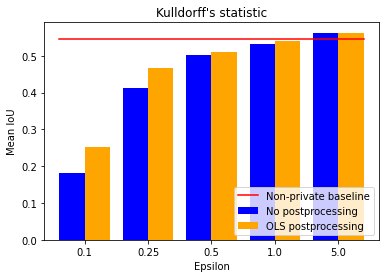

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.title(f"Kulldorff's statistic")
plt.xlabel("Epsilon")
plt.ylabel("Mean IoU")
ind = np.arange(len(EPSILONS))
width = 0.4
# plot accuracy vs. epsilon for unprocessed private
plt.bar(ind - width/2, private_mean_ious, width, color="blue", label="No postprocessing")
# plot accuracy vs. epsilon for OLS postprocessed
plt.bar(ind + width/2, ols_mean_ious, width, color="orange", label="OLS postprocessing")
plt.xticks(ind, [str(x) for x in EPSILONS])
# draw non-private baseline
plt.plot([-width, max(ind) + width], [nonprivate_mean_iou] * 2, label="Non-private baseline", color="red")
plt.legend(loc="lower right")

## EBP Scan Statistic
Computes accuracy of expectation-based Poisson (EBP) scan statistic, with and without post processing.

In [4]:
import numpy as np
import cluster
import util
from shapely import geometry
from cormode import gen, private
from cormode.classical import QuadTreeNode
from cormode import postprocessing


# poisson parameter for number of background cases.
lambda_background = POPULATION * BACKGROUND_INCIDENCE_RATE
# poisson parameter for number of cluster cases.
lambda_cluster = POPULATION * CLUSTER_INCIDENCE_RATE

nonprivate_ious = []
private_mean_ious = []
ols_mean_ious = []

# try each value of epsilon
for epsilon in EPSILONS:
    private_ious = []
    ols_ious = []
    for iter in range(ITERS):
        # data generation

        # pick circular region to be our cluster
        cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
        cluster_radius = np.random.uniform(0.1, 0.25)
        cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

        # generate some data
        points = gen.generate_points_single_cluster(
            geometry.box(0,0,1,1),
            lambda_background,
            cluster_region,
            lambda_cluster
        )
        
        # build non-private quadtree on these points
        tree = QuadTreeNode(height=QUADTREE_HEIGHT)
        for point in points:
            tree.insert_point(point)

        # build private quadtree from the non-private one
        private_tree = private.make_private_quadtree(tree, epsilon_total=epsilon, budget_strategy=private.BudgetStrategy.GEOMETRIC)
        ols_tree = postprocessing.build_ols_tree(private_tree)

        # find cluster regions using EBP
        _, nonprivate_region = cluster.find_max_ebp_sweep(tree, lambda_background)
        _, private_region = cluster.find_max_ebp_sweep(private_tree, lambda_background)
        _, ols_region = cluster.find_max_ebp_sweep(ols_tree, lambda_background)

        # compute IoU for each region
        nonprivate_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*nonprivate_region))
        private_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*private_region))
        ols_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*ols_region))

        nonprivate_ious.append(nonprivate_iou)
        private_ious.append(private_iou)
        ols_ious.append(ols_iou)

    private_mean_ious.append(np.mean(private_ious))
    ols_mean_ious.append(np.mean(ols_ious))
nonprivate_mean_iou = np.mean(nonprivate_ious)    

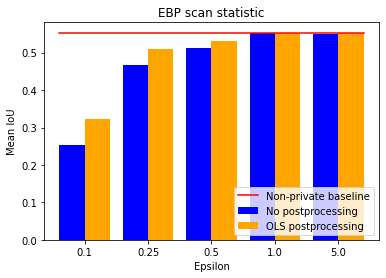

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.title(f"EBP scan statistic")
plt.xlabel("Epsilon")
plt.ylabel("Mean IoU")
ind = np.arange(len(EPSILONS))
width = 0.4
# plot accuracy vs. epsilon for unprocessed private
plt.bar(ind - width/2, private_mean_ious, width, color="blue", label="No postprocessing")
# plot accuracy vs. epsilon for OLS postprocessed
plt.bar(ind + width/2, ols_mean_ious, width, color="orange", label="OLS postprocessing")
plt.xticks(ind, [str(x) for x in EPSILONS])
# draw non-private baseline
plt.plot([-width, max(ind) + width], [nonprivate_mean_iou] * 2, label="Non-private baseline", color="red")
plt.legend(loc="lower right")

## Comparing scan statistics
Computes accuracy of Kulldorff and EBG (with OLS postprocessing) and plots comparison.

In [3]:
import numpy as np
import cluster
import util
from shapely import geometry
from cormode import gen, private
from cormode.classical import QuadTreeNode
from cormode import postprocessing


# poisson parameter for number of background cases.
lambda_background = POPULATION * BACKGROUND_INCIDENCE_RATE
# poisson parameter for number of cluster cases.
lambda_cluster = POPULATION * CLUSTER_INCIDENCE_RATE

ebp_nonprivate_ious = []
ebp_mean_ious = []

kulldorff_nonprivate_ious = []
kulldorff_mean_ious = []

# try each value of epsilon
for epsilon in EPSILONS:
    ebp_ious = []
    kulldorff_ious = []

    for iter in range(ITERS):
        # data generation

        # pick circular region to be our cluster
        cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
        cluster_radius = np.random.uniform(0.1, 0.25)
        cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

        # generate some data
        points = gen.generate_points_single_cluster(
            geometry.box(0,0,1,1),
            lambda_background,
            cluster_region,
            lambda_cluster
        )
        
        # build non-private quadtree on these points
        tree = QuadTreeNode(height=QUADTREE_HEIGHT)
        for point in points:
            tree.insert_point(point)

        # build private quadtree from the non-private one
        private_tree = private.make_private_quadtree(tree, epsilon_total=epsilon, budget_strategy=private.BudgetStrategy.GEOMETRIC)
        ols_tree = postprocessing.build_ols_tree(private_tree)

        # find cluster regions using EBP
        _, ebp_nonprivate_region = cluster.find_max_ebp_sweep(tree, lambda_background)
        _, ebp_ols_region = cluster.find_max_ebp_sweep(ols_tree, lambda_background)

        _, kulldorff_nonprivate_region = cluster.find_max_kulldorff_sweep(tree, POPULATION)
        _, kulldorff_ols_region = cluster.find_max_kulldorff_sweep(ols_tree, POPULATION)

        # compute IoU for each region
        ebp_nonprivate_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*ebp_nonprivate_region))
        ebp_ols_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*ebp_ols_region))

        kulldorff_nonprivate_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*kulldorff_nonprivate_region))
        kulldorff_ols_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*kulldorff_ols_region))

        ebp_nonprivate_ious.append(ebp_nonprivate_iou)
        ebp_ious.append(ebp_ols_iou)

        kulldorff_nonprivate_ious.append(kulldorff_nonprivate_iou)
        kulldorff_ious.append(kulldorff_ols_iou)
    
    ebp_mean_ious.append(np.mean(ebp_ious))
    kulldorff_mean_ious.append(np.mean(kulldorff_ious))

ebp_nonprivate_mean_iou = np.mean(ebp_nonprivate_ious)
kulldorff_nonprivate_mean_iou = np.mean(kulldorff_nonprivate_ious)

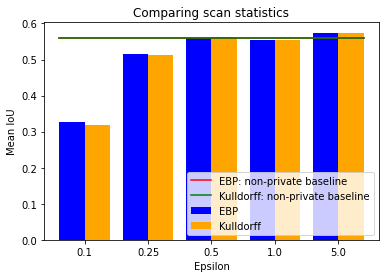

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title(f"Comparing scan statistics")
plt.xlabel("Epsilon")
plt.ylabel("Mean IoU")
ind = np.arange(len(EPSILONS))
width = 0.4
# plot accuracy vs. epsilon for unprocessed private
plt.bar(ind - width/2, ebp_mean_ious, width, color="blue", label="EBP")
# plot accuracy vs. epsilon for OLS postprocessed
plt.bar(ind + width/2, kulldorff_mean_ious, width, color="orange", label="Kulldorff")
plt.xticks(ind, [str(x) for x in EPSILONS])
# draw non-private baseline
plt.plot([-width, max(ind) + width], [ebp_nonprivate_mean_iou] * 2, label="EBP: non-private baseline", color="red")
plt.plot([-width, max(ind) + width], [kulldorff_nonprivate_mean_iou] * 2, label="Kulldorff: non-private baseline", color="green")
plt.legend(loc="lower right")